<a href="https://colab.research.google.com/github/miguel-kjh/Analysis-of-tweets/blob/main/Deep_Learning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we carry out the classification using an approach based on Deep Learning and word embedding, we use:

- CNN with kernel = 1
- Fast Sentiment
- BETO + GRU: The BERT model trained for Spanish

As metric we use the **f-score** and the **accuracy**.I have also used torchtext which allows you to load data from files and use pyTorch targets and iterators to facilitate training and validation. 



In [ ]:
import torch

import random
import numpy as np

import torchtext

from torchtext import data
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.5MB 9.1MB/s 
     |████████████████████████████████| 2.9MB 35.1MB/s 
     |████████████████████████████████| 890kB 29.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=814b137048f712e78aeba560f8b229529acc9161f687c2cd96a17bbafa0bac60
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/My Drive/SIANI Master/CI/Práctica/spanish-arilines-tweets-sentiment-analysis'
!ls '/content/drive/My Drive/SIANI Master/CI/Práctica/spanish-arilines-tweets-sentiment-analysis'

Mounted at /content/drive
baseline.ipynb	      test_data_un.csv	 tweets_public.csv	val_data_ba.csv
sampleSubmission.csv  train_data_ba.csv  tweets_public.xlsx	val_data_un.csv
test_data_ba.csv      train_data_un.csv  tweets_submission.csv


The following functions implement the logic necessary to calculate precision, train, and visualize data regarding the behavior of the model. 

In [ ]:
def generatePlot(acc,val_acc, model_str):
   
  epochs = range(len(acc))
   
  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy %s' % model_str)
  plt.legend()
   
  plt.show()

In [ ]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc  = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = categorical_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def fit(model, name, N_EPOCHS = 50):
  
  best_valid_loss = float('inf')
  train_list = []
  valid_list = []

  for epoch in range(N_EPOCHS):

      start_time = time.time()
      
      train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
      valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
      
      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), name)

      train_list.append(train_acc*100)
      valid_list.append(valid_acc*100)
      
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
  
  return train_list, valid_list

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = categorical_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def report(model, iterator):
    
    model.eval()
    predict = []
    Ytest   = []

    with torch.no_grad():
        for batch in iterator:
          predictions = model(batch.text).squeeze(1)
          max_preds = predictions.argmax(dim = 1, keepdim = True) # get the index of the max probability
          correct  = max_preds.squeeze(1).eq(batch.label)
          predict += max_preds.squeeze(1).tolist()
          Ytest   += batch.label.tolist()

    print(classification_report(Ytest, predict))


In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## CNN

- Kernel = 1
- Tokenizer: SpaCy
- Language model: Glove for Spanish

In [ ]:
quote  = data.Field(tokenize = 'spacy')
score  = data.LabelField()

In [ ]:
fields = {'quote': ('text', quote), 'score': ('label', score)}

train_data, valid_data, test_data = data.TabularDataset.splits(
  path        =  data_dir,
  train       = 'train_data_ba.csv',
  validation  = 'val_data_ba.csv',
  test        = 'test_data_ba.csv',
  format      = 'csv',
  fields      = fields
)

print(f"Number of training examples:   {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples:    {len(test_data)} ")

Number of training examples:   9381
Number of validation examples: 2680
Number of testing examples:    1340 


In [ ]:
MAX_VOCAB_SIZE = 25_000

quote.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors  = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

score.build_vocab(train_data)

In [ ]:
print(score.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f00e0a15ea0>, {'1': 0, '2': 1, '0': 2})


In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
                
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In this cell are the hyperparameters of the model 

In [ ]:
INPUT_DIM = len(quote.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,2,2]
OUTPUT_DIM = len(score.vocab)
DROPOUT = 0.5
PAD_IDX = quote.vocab.stoi[quote.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,198,603 trainable parameters


In [ ]:
pretrained_embeddings = quote.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = quote.vocab.stoi[quote.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
name_model = 'CNN-model.pt'
train_list,valid_list = fit(model, name_model)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 1.054 | Train Acc: 43.49%
	 Val. Loss: 0.945 |  Val. Acc: 56.16%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.896 | Train Acc: 58.05%
	 Val. Loss: 0.850 |  Val. Acc: 62.02%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.764 | Train Acc: 66.56%
	 Val. Loss: 0.768 |  Val. Acc: 67.23%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.658 | Train Acc: 73.29%
	 Val. Loss: 0.727 |  Val. Acc: 70.59%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.569 | Train Acc: 77.81%
	 Val. Loss: 0.652 |  Val. Acc: 73.33%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.473 | Train Acc: 81.85%
	 Val. Loss: 0.594 |  Val. Acc: 75.63%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.430 | Train Acc: 83.59%
	 Val. Loss: 0.605 |  Val. Acc: 76.56%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.380 | Train Acc: 85.92%
	 Val. Loss: 0.549 |  Val. Acc: 77.56%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.325 | Train Acc: 87.37%
	 Val. Loss: 0.552 |  Val. Acc: 77.94%
Epoch: 10 | Epoch Time: 0m 0

In [ ]:
model.load_state_dict(torch.load(name_model))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.599 | Test Acc: 79.42%


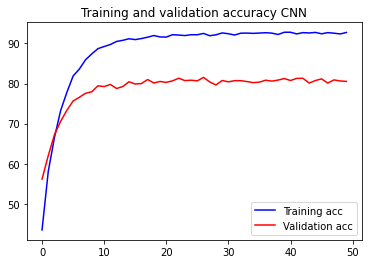

In [ ]:
generatePlot(train_list,valid_list, "CNN")

In [ ]:
report(model, test_iterator)

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       448
           1       0.81      0.88      0.84       438
           2       0.81      0.81      0.81       454

    accuracy                           0.79      1340
   macro avg       0.79      0.79      0.79      1340
weighted avg       0.79      0.79      0.79      1340



##  Transformers for Sentiment Analysis

The BETO already comes with its own language model and its own tokenizer adapted to Spanish. 


In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
bert      = BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

In [ ]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx  = tokenizer.sep_token_id
pad_token_idx  = tokenizer.pad_token_id
unk_token_idx  = tokenizer.unk_token_id

In [ ]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [ ]:
quote = data.Field(
    batch_first   = True,
    use_vocab     = False, 
    tokenize      = tokenize_and_cut,
    preprocessing = tokenizer.convert_tokens_to_ids,
    init_token    = init_token_idx,
    eos_token     = eos_token_idx,
    pad_token     = pad_token_idx,
    unk_token     = unk_token_idx,
    lower         = True)

score = data.LabelField()

In [ ]:
fields = {'quote': ('text', quote), 'score': ('label', score)}

train_data, valid_data, test_data = data.TabularDataset.splits(
  path        =  data_dir,
  train       = 'train_data_ba.csv',
  validation  = 'val_data_ba.csv',
  test        = 'test_data_ba.csv',
  format      = 'csv',
  fields      = fields
)

In [ ]:
print(f"Number of training examples:   {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples:    {len(test_data)} ")

Number of training examples:   9381
Number of validation examples: 2680
Number of testing examples:    1340 


In [ ]:
print(vars(train_data.examples[6]))

{'text': [19000, 6568, 1861, 2467, 1112, 10640, 8972, 1409, 3959, 3254, 13780, 3969], 'label': '0'}


In [ ]:
score.build_vocab(train_data)

In [ ]:
print(score.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f00e0a15ea0>, {'1': 0, '2': 1, '0': 2})


In [ ]:
BATCH_SIZE = 128
print(device)
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

cuda


In [ ]:
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']

        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output


Network hyperparameters 

In [ ]:
HIDDEN_DIM    = 512
OUTPUT_DIM    = len(score.vocab)
N_LAYERS      = 6
BIDIRECTIONAL = True
DROPOUT       = 0.15

In [ ]:
model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

The model has 137,415,939 trainable parameters
The model has 27,565,059 trainable parameters
rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
rnn.weight_ih_l2
rnn.weight_hh_l2
rnn.bias_ih_l2
rnn.bias_hh_l2
rnn.weight_ih_l2_reverse
rnn.weight_hh_l2_reverse
rnn.bias_ih_l2_reverse
rnn.bias_hh_l2_reverse
rnn.weight_ih_l3
rnn.weight_hh_l3
rnn.bias_ih_l3
rnn.bias_hh_l3
rnn.weight_ih_l3_reverse
rnn.weight_hh_l3_reverse
rnn.bias_ih_l3_reverse
rnn.bias_hh_l3_reverse
rnn.weight_ih_l4
rnn.weight_hh_l4
rnn.bias_ih_l4
rnn.bias_hh_l4
rnn.weight_ih_l4_reverse
rnn.weight_hh_l4_reverse
rnn.bias_ih_l4_reverse
rnn.bias_hh_l4_reverse
rnn.weight_ih_l5
rnn.weight_hh_l5
rnn.bias_ih_l5
rnn.bias_hh_l5
rnn.weight_ih_l5_reverse
rnn.weight_hh_l5_r

In [ ]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()
model     = model.to(device)
criterion = criterion.to(device)

In [ ]:
name_model = 'BETO-model.pt'
train_list,valid_list = fit(model, name_model)

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 1.232 | Train Acc: 38.01%
	 Val. Loss: 0.976 |  Val. Acc: 50.89%
Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 0.991 | Train Acc: 48.78%
	 Val. Loss: 1.011 |  Val. Acc: 45.02%
Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 0.957 | Train Acc: 51.92%
	 Val. Loss: 0.914 |  Val. Acc: 55.06%
Epoch: 04 | Epoch Time: 0m 24s
	Train Loss: 0.919 | Train Acc: 54.84%
	 Val. Loss: 0.905 |  Val. Acc: 54.28%
Epoch: 05 | Epoch Time: 0m 24s
	Train Loss: 0.904 | Train Acc: 55.47%
	 Val. Loss: 0.891 |  Val. Acc: 56.62%
Epoch: 06 | Epoch Time: 0m 24s
	Train Loss: 0.869 | Train Acc: 58.70%
	 Val. Loss: 0.863 |  Val. Acc: 59.63%
Epoch: 07 | Epoch Time: 0m 24s
	Train Loss: 0.825 | Train Acc: 60.47%
	 Val. Loss: 0.806 |  Val. Acc: 61.89%
Epoch: 08 | Epoch Time: 0m 24s
	Train Loss: 0.783 | Train Acc: 63.48%
	 Val. Loss: 0.785 |  Val. Acc: 64.70%
Epoch: 09 | Epoch Time: 0m 24s
	Train Loss: 0.744 | Train Acc: 65.93%
	 Val. Loss: 0.780 |  Val. Acc: 65.32%
Epoch: 10 | Epoch T

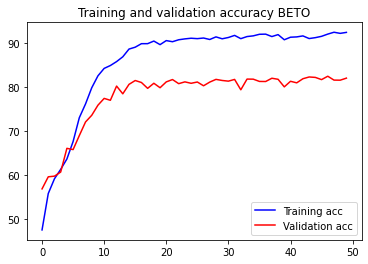

In [ ]:
generatePlot(train_list,valid_list, "BETO")

In [ ]:
model.load_state_dict(torch.load(name_model))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.613 | Test Acc: 77.84%


In [ ]:
report(model, test_iterator)

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       448
           1       0.82      0.81      0.81       438
           2       0.82      0.81      0.81       454

    accuracy                           0.78      1340
   macro avg       0.78      0.78      0.78      1340
weighted avg       0.78      0.78      0.78      1340



## Faster Sentiments

This model has far fewer parameters than the previous model as it only has 2 layers that have any parameters, the embedding layer and the linear layer.

- Tokenizer: SpaCy
- Language model: Glove for Spanish

In [ ]:
def generate_bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return x

In [ ]:
quote  = data.Field(tokenize = 'spacy')
score  = data.LabelField()

In [ ]:
fields = {'quote': ('text', quote), 'score': ('label', score)}

train_data, valid_data, test_data = data.TabularDataset.splits(
  path        =  data_dir,
  train       = 'train_data_ba.csv',
  validation  = 'val_data_ba.csv',
  test        = 'test_data_ba.csv',
  format      = 'csv',
  fields      = fields
)

print(f"Number of training examples:   {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples:    {len(test_data)} ")

Number of training examples:   9381
Number of validation examples: 2680
Number of testing examples:    1340 


In [ ]:
MAX_VOCAB_SIZE = 25_000

quote.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

score.build_vocab(train_data)

In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FastText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
                
        #embedded = [sent len, batch size, emb dim]
        
        embedded = embedded.permute(1, 0, 2)
        
        #embedded = [batch size, sent len, emb dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        
        #pooled = [batch size, embedding_dim]
                
        return self.fc(pooled)

In [ ]:
INPUT_DIM = len(quote.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = len(score.vocab)
PAD_IDX = quote.vocab.stoi[quote.pad_token]

model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,137,703 trainable parameters


In [ ]:
pretrained_embeddings = quote.vocab.vectors

UNK_IDX = quote.vocab.stoi[quote.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
name_model = 'fast-RNN-model.pt'
train_list,valid_list = fit(model, name_model)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 1.074 | Train Acc: 41.01%
	 Val. Loss: 1.046 |  Val. Acc: 46.61%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 1.002 | Train Acc: 51.63%
	 Val. Loss: 0.986 |  Val. Acc: 52.03%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.918 | Train Acc: 59.01%
	 Val. Loss: 0.921 |  Val. Acc: 57.18%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.826 | Train Acc: 64.99%
	 Val. Loss: 0.859 |  Val. Acc: 60.20%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.734 | Train Acc: 70.06%
	 Val. Loss: 0.803 |  Val. Acc: 64.33%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.650 | Train Acc: 74.53%
	 Val. Loss: 0.755 |  Val. Acc: 67.09%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.574 | Train Acc: 78.58%
	 Val. Loss: 0.714 |  Val. Acc: 68.85%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.507 | Train Acc: 81.17%
	 Val. Loss: 0.679 |  Val. Acc: 70.48%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.451 | Train Acc: 83.02%
	 Val. Loss: 0.650 |  Val. Acc: 72.25%
Epoch: 10 | Epoch Time: 0m 0

In [ ]:
model.load_state_dict(torch.load(name_model))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.565 | Test Acc: 78.23%


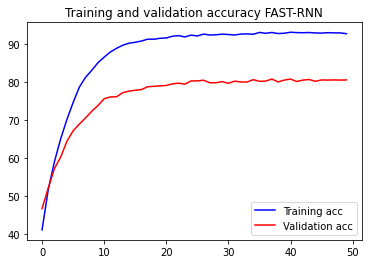

In [ ]:
generatePlot(train_list,valid_list, "FAST-RNN")

In [ ]:
report(model, test_iterator)

              precision    recall  f1-score   support

           0       0.64      0.70      0.67       375
           1       0.46      0.47      0.46       262
           2       0.41      0.31      0.35       150

    accuracy                           0.55       787
   macro avg       0.50      0.49      0.49       787
weighted avg       0.54      0.55      0.54       787

